Click [here]() to access the associated Medium article.

# Setup

In [1]:
!pip install -q polars

In [2]:
import polars as pl

pl.__version__

'0.19.3'

# Dataset

In [3]:
import random
import string

import polars as pl

# Defining the size of our dataset
size = 1000000

# Setting a seed for reproducibility
random.seed(777)

# Creating a DataFrame
df = pl.DataFrame(
    {
        "age": [random.randint(20, 70) for _ in range(size)],
        "city": [
            random.choice(["New York", "London", "Berlin", "Tokyo"])
            for _ in range(size)
        ],
        "is_married": [random.choice([True, False]) for _ in range(size)],
        "bmi": [round(random.uniform(17.0, 27.0), 2) for _ in range(size)],
    }
)

## Inspecting the Dataset

In [4]:
df.shape

(1000000, 4)

In [5]:
df.head()

age,city,is_married,bmi
i64,str,bool,f64
34,"""New York""",false,17.62
48,"""Tokyo""",true,25.62
48,"""Tokyo""",false,18.25
43,"""London""",true,17.73
56,"""Berlin""",false,21.42


In [6]:
df.describe()

describe,age,city,is_married,bmi
str,f64,str,f64,f64
"""count""",1e6,"""1000000""",1e6,1e6
"""null_count""",0.0,"""0""",0.0,0.0
"""mean""",45.007378,null,0.498941,21.998514
"""std""",14.714038,null,0.499999,2.885383
"""min""",20.0,"""Berlin""",0.0,17.0
"""25%""",32.0,null,null,19.5
"""50%""",45.0,null,null,22.0
"""75%""",58.0,null,null,24.5
"""max""",70.0,"""Tokyo""",1.0,27.0


# Data Cleaning

## Missing Values

In [7]:
# Create some missing data.
# Whenever 'age' is over 68, corresponding 'bmi' becomes 'null'
df = df.with_columns(
    pl.when(pl.col("age") > 68).then(None).otherwise(pl.col("bmi")).alias(
        "bmi"
    )
)

In [8]:
# Counting missing values
df.null_count()

age,city,is_married,bmi
u32,u32,u32,u32
0,0,0,39283


In [9]:
# Imputing missing values with the median of the column 'bmi'
df = df.with_columns(pl.col("bmi").fill_null(pl.median("bmi")))

# Counting missing values again
df.null_count()

age,city,is_married,bmi
u32,u32,u32,u32
0,0,0,0


## Type Casting

In [10]:
# Casting 'bmi' to integer (show only).
df.select(pl.col('bmi').cast(pl.Int32))

bmi
i32
17
25
18
17
21
26
18
17
25


In [11]:
# Original 'bmi'
df.select(pl.col('bmi'))

bmi
f64
17.62
25.62
18.25
17.73
21.42
26.79
18.74
17.66
25.02


## Creating New Columns

In [12]:
# Create a new column 'age_in_months' (show only)
df.with_columns((pl.col("age") * 12).alias("age_in_months"))

age,city,is_married,bmi,age_in_months
i64,str,bool,f64,i64
34,"""New York""",false,17.62,408
48,"""Tokyo""",true,25.62,576
48,"""Tokyo""",false,18.25,576
43,"""London""",true,17.73,516
56,"""Berlin""",false,21.42,672
37,"""London""",false,26.79,444
41,"""Berlin""",true,18.74,492
54,"""Tokyo""",true,17.66,648
68,"""London""",false,25.02,816


## Removing Duplicates

In [13]:
# Save only unique values in the dataset
df = df.unique()

# Data Visualization

In [14]:
import plotly.express as px

import matplotlib.pyplot as plt

In [15]:
sample_df = df.sample(1000)

## Histogram

In [16]:
fig=px.histogram(sample_df, x="bmi", nbins=10)

# save to file
# fig.write_image("histogram.png")

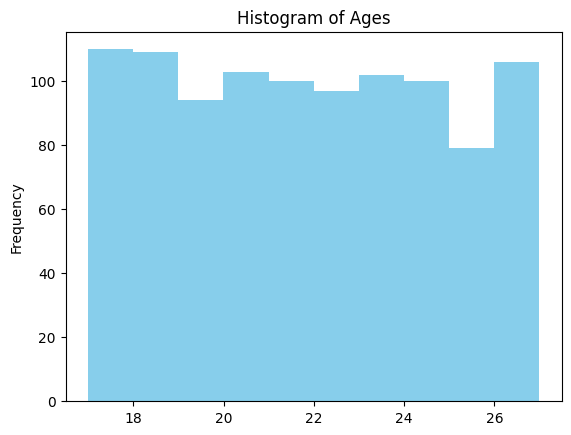

In [17]:
plt.hist(sample_df['bmi'], bins=10, color = "skyblue")
plt.title('Histogram of Ages')
plt.ylabel('Frequency')
plt.show()

## Box Plot

In [18]:
# px.box(df, y="age")

## Scatter Plot

In [19]:
# px.scatter(df.sample(100), x="age", y="bmi")

## Bar Chart

In [20]:
# px.bar(df, y="city")